In [1]:
%pip install albumentations
%pip install torchvision

  Using cached numpy-1.24.4-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp38-cp38-macosx_11_0_arm64.whl (13.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.24.4 which is incompatible.
tensorflow-macos 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.8.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### [Documentation](https://albumentations.ai/docs/)

### [Demo](https://demo.albumentations.ai/)

In [12]:
import random

import cv2
import numpy as np
import albumentations as albu
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

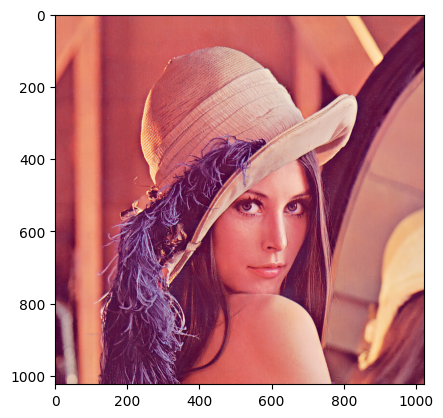

In [13]:
img = cv2.imread("lenna.png")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img);

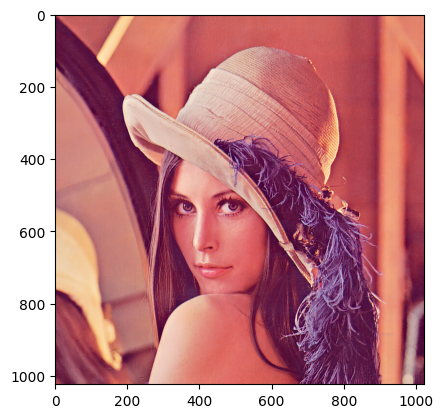

In [25]:
transform = albu.HorizontalFlip(p=0.5)
# random.seed(42)
result = transform(image=rgb_img)
plt.imshow(result["image"]);

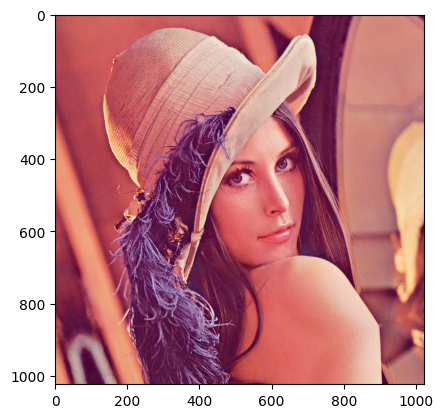

In [31]:
transform = albu.ShiftScaleRotate(shift_limit=0.1, rotate_limit=30, p=0.5)
# random.seed(42)
result = transform(image=rgb_img)
plt.imshow(result["image"]);

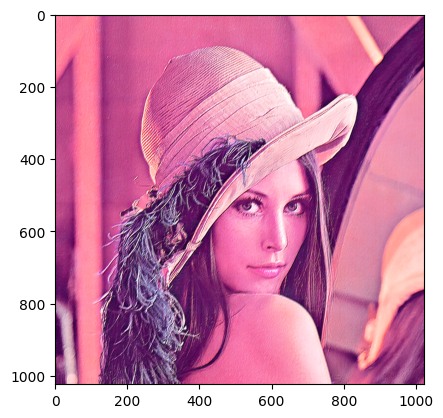

In [42]:
transform = albu.Compose([
    albu.CLAHE(clip_limit=2),
    albu.Sharpen(),
    albu.Emboss(p=0.5),
    albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2),
    albu.Blur(),
    albu.MotionBlur(),
    albu.ImageCompression(quality_lower=85, quality_upper=100),
    albu.ColorJitter(),
    albu.OpticalDistortion(),
])

# random.seed(42)
result = transform(image=rgb_img)
plt.imshow(result["image"]);

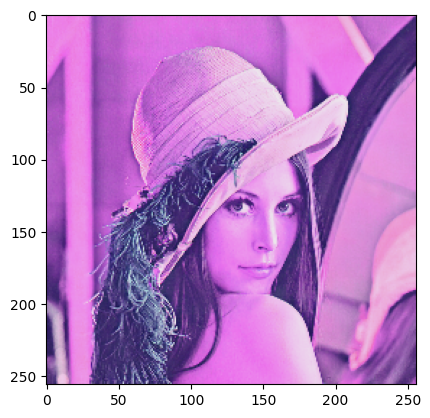

In [46]:
transform = albu.Compose([
    albu.OneOf([
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_REPLICATE),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_REFLECT),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_WRAP),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_REFLECT_101),
    ], p=0.5),
    albu.OneOf([
        albu.CLAHE(clip_limit=2),
        albu.Sharpen(),
        albu.Emboss(),
        albu.Equalize(),
        albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2),
    ], p=0.3),
    albu.OneOf([
        albu.Blur(),
        albu.MotionBlur(),
        albu.ImageCompression(quality_lower=85, quality_upper=100),
        albu.ColorJitter(),
        albu.OpticalDistortion(),
    ], p=0.75),
    albu.HorizontalFlip(),
    albu.Resize(256, 256),
    albu.Normalize(mean=0, std=1),
])
# random.seed(42)
result = transform(image=rgb_img)
plt.imshow(result["image"]);

In [67]:
class AugmentedDataset(Dataset):
    def __init__(self, images: "List[str]", labels: "np.ndaray", augmentations: albu.Compose=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.augs = augmentations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index: int) -> tuple:
        img_path = self.images[index]

        # read image
        raw_img = cv2.imread(img_path) # BGR
        # change color space
        rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB) # BGR -> RGB

        # apply augmentations
        if self.augs is not None:
            # img = transform(image=rgb_img)["image"]
            img = self.augs(image=rgb_img)["image"]
        else:
            img = cv2.resize(rgb_img, (256, 256)) / 255.0

        img_tensor = torch.from_numpy(img)
        labels = torch.LongTensor([self.labels[index]])

        return img_tensor, labels

In [68]:
train_data = AugmentedDataset(
    images=["lenna.png"],
    labels=[0],
    augmentations=transform
)

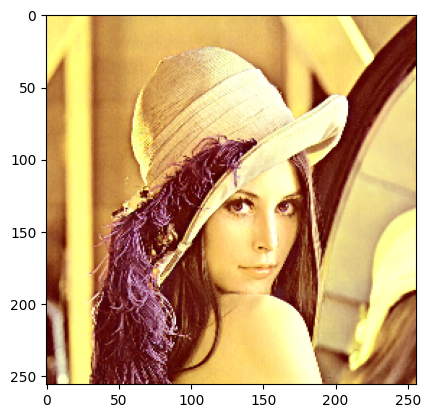

In [69]:
plt.imshow(train_data.__getitem__(0)[0]);